In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import os
from dotenv import load_dotenv

# Подключение к БД

In [16]:
load_dotenv(dotenv_path=r'C:\Users\User\Downloads\Пет-проекты\marketplace_users_data\config.env')  # Загрузка переменных из .env

db_url = f"postgresql://{os.getenv('DB_USER')}:{os.getenv('DB_PASSWORD')}@{os.getenv('DB_HOST')}/{os.getenv('DB_NAME')}"
engine = create_engine(db_url)

In [26]:
query = """
    SELECT u.id as user_id, u.name, p.id as purchase_id, p.purchase_date, p.category, p.amount 
    FROM purchases p 
        JOIN users u ON p.user_id = u.id;
"""

In [27]:
df = pd.read_sql(query, engine, parse_dates=['purchase_date'])
df.sort_values('purchase_date')

,user_id,name,purchase_id,purchase_date,category,amount
718,61,Lauren Zimyerman,719,2023-02-11,UNKNOWN CATEGORY,829.120
2337,124,Alexander Spencer,2338,2023-02-12,TOYS,75.370
2404,441,Shauq Stone,2405,2023-03-12,CLOTHING,924.240
22,98,Rachel Reyes,23,2023-04-12,BOOKS,765.790
403,101,Scott Hernandez,404,2023-05-12,UNKNOWN CATEGORY,504.095
...,...,...,...,...,...,...
223,179,Alyssa Mitchell,224,2025-10-10,TOYS,414.660
7,424,Laura Watson,8,2025-10-10,BOOKS,305.320
190,197,Charles Watson,191,2025-10-10,COSMETICS,87.290
594,25,Nicholas Mullins,595,2025-10-10,SPORTS,529.890


## Краткий разведочный анализ

Размерность датафрейма

In [8]:
df.shape

(3000, 6)

Проверка типов признаков

In [9]:
df.dtypes

id                        int64
name                     object
purchase_id               int64
purchase_date    datetime64[ns]
category                 object
amount                  float64
dtype: object

Проверка значений на null

In [10]:
df.isnull().sum()

id               0
name             0
purchase_id      0
purchase_date    0
category         0
amount           0
dtype: int64

Просмотр количеств уникальных значений

In [11]:
df.nunique()

id                500
name              472
purchase_id      3000
purchase_date     732
category            8
amount           2807
dtype: int64

Проверка на дубликаты

In [12]:
df.duplicated().sum()

np.int64(0)

Проверка на будущие даты

In [ ]:
future_dates = df[df['purchase_date'] > pd.Timestamp.today()]
if future_dates.empty:
    print("DataFrame не содержит будущих дат")
else:
    print(f"DataFrame содержит будущие даты:\n{future_dates['purchase_date']}")

DataFrame не содержит будущих дат


__Вывод__: все данные полность пригодны к анализу.

# RFM-анализ

За дату исследования возьмём последнюю дату покупки в данных

In [25]:
last_date = df['purchase_date'].max()
last_date

Timestamp('2025-10-10 00:00:00')

Создадим датафрейм с RFM-метриками: Recency (давность последней покупки), Frequency (частота покупок) и Monetary (общая сумма покупок)

In [29]:
rfm = df.groupby('user_id').agg(
    recency = ('purchase_date', lambda x: (last_date - x.max()).days),
    frequency = ('purchase_id', 'count'),
    monetary = ('amount', 'sum')
).reset_index()

rfm.head()

,user_id,recency,frequency,monetary
0,1,311,5,2410.920
1,2,154,7,3354.285
2,3,255,6,2645.130
3,4,39,7,3134.420
4,5,95,6,3807.335


Распределим клиентов по группам    
Данные разбиваются на 3 группы так, чтобы в каждой было примерно одинаковое число пользователей (три квантиля)
1. Recency.    
Присваиваем метки [3][2][1]: самая высокая метка (1) соответствует самой низкой по значению recency, то есть самым «свежим» покупателям, а 3 — самым «старыми»
2. Frequency    
Присваиваем метки [1][2][3]: здесь метка 3 соответствует наиболее активным по числу покупок пользователям
3. Monetary   
Присваиваем метки [1][2][3]: здесь метка 3 соответствует пользователям с наибольшими суммами покупо.

In [30]:
rfm['R'] = pd.qcut(rfm['recency'], q=3, labels=[3, 2, 1])
rfm['F'] = pd.qcut(rfm['frequency'].rank(method='first'), q=3, labels=[1, 2, 3])
rfm['M'] = pd.qcut(rfm['monetary'], q=3, labels=[1, 2, 3])
rfm.head()

,user_id,recency,frequency,monetary,R,F,M
0,1,311,5,2410.920,1,1,2
1,2,154,7,3354.285,2,2,2
2,3,255,6,2645.130,1,2,2
3,4,39,7,3134.420,3,2,2
4,5,95,6,3807.335,2,2,3


Объединим группы в один столбец

In [31]:
rfm['RFM'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)
rfm.head()

,user_id,recency,frequency,monetary,R,F,M,RFM
0,1,311,5,2410.920,1,1,2,112
1,2,154,7,3354.285,2,2,2,222
2,3,255,6,2645.130,1,2,2,122
3,4,39,7,3134.420,3,2,2,322
4,5,95,6,3807.335,2,2,3,223


In [32]:
rfm['RFM'].value_counts()

RFM
333    65
111    63
211    40
233    39
222    33
322    32
122    30
133    29
311    26
223    19
112    17
121    17
332    15
212    12
232    12
221    11
323    10
312     9
321     9
132     6
123     5
331     1
Name: count, dtype: int64

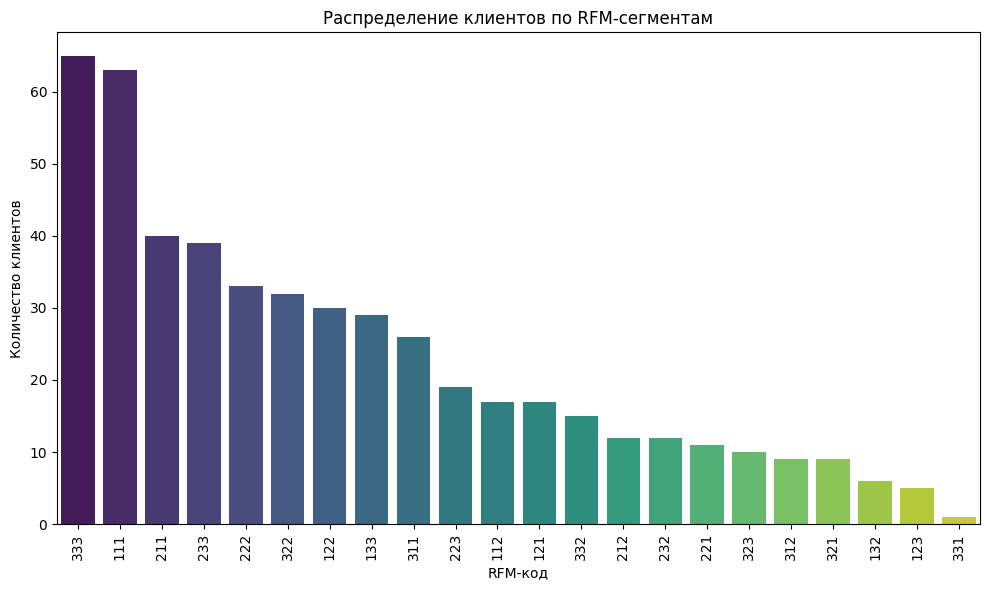

In [33]:
rfm_counts = rfm['RFM'].value_counts().reset_index()
rfm_counts.columns = ['RFM', 'count']

plt.figure(figsize=(10, 6))
sns.barplot(data=rfm_counts, x='RFM', y='count', hue='RFM', palette='viridis')

plt.title('Распределение клиентов по RFM-сегментам')
plt.xlabel('RFM-код')
plt.ylabel('Количество клиентов')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

## Выводы и рекомендации

- **Группа 333**: недавние, частые, дорогие
	- *Рекомендации*: удержание, персонализация, премиальные предложения
- **Группа 111**: давно не покупали, редко, дешёвые
	- *Рекомендации*: реанимационные кампании, опросы
- **Группы 233/332/211**: есть признаки активности и ценности
	- *Рекомендации*: стимулировать повтор, бонусы за лояльность
- **Группы 133/313/231**: редкие, но дорогие
	- *Рекомендации*: эксклюзивные предложения, персональные обращения